# Clustering Notebook
- Perform K-Means and Spectral Clustering on fashion mnist data

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, \
AgglomerativeClustering, SpectralClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.model_selection import train_test_split

RANDOM_STATE = 598

In [2]:
# map labels to actual names
label_map = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
             3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt',
             7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

# load processed data
with np.load('fashion_mnist_processed.npz') as data:
    X_pca = data['X_train_pca']
    y_train = data['y_train']
    X_scaled = data['X_train_scaled'] 
    
print(f"X_pca Shape: {X_pca.shape}")
print(f"X_scaled Shape: {X_scaled.shape}")
print(f"y_train Shape: {y_train.shape}")

X_pca Shape: (60000, 256)
X_scaled Shape: (60000, 784)
y_train Shape: (60000,)


# 1b: Clustering

## K-Means
- systematic k selection using Silhouette score

K=8, silhouette=0.1156
K=10, silhouette=0.1299
K=12, silhouette=0.1196
K=14, silhouette=0.1094


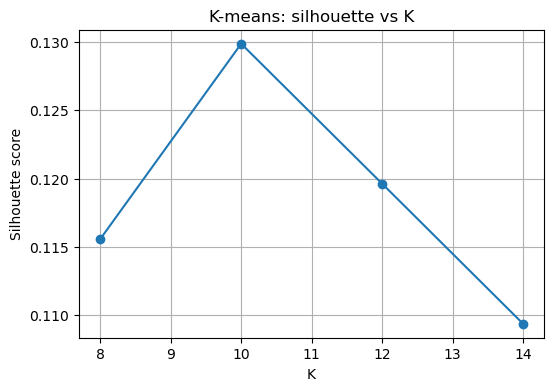

In [7]:
k_values = [8, 10, 12, 14]
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
    cluster_labels = km.fit_predict(X_pca)
    score = silhouette_score(X_pca, cluster_labels)
    sil_scores.append(score)
    print(f"K={k}, silhouette={score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(k_values, sil_scores, marker="o")
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.title("K-means: silhouette vs K")
plt.grid(True)
plt.show()

In [8]:
best_k = k_values[int(np.argmax(sil_scores))]

kmeans_final = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init="auto")
clusters_km = kmeans_final.fit_predict(X_pca)

In [9]:
df_res = pd.DataFrame({'Cluster': clusters_km, 'Label': y_train})
df_res['Label_Name'] = df_res['Label'].map(label_map)

ct_km = pd.crosstab(df_res['Cluster'], df_res['Label_Name'])

# determine dominating label
print("\nDominating Label per Cluster:")
for cluster_id in sorted(df_res['Cluster'].unique()):
    cluster_counts = df_res[df_res['Cluster'] == cluster_id]['Label_Name'].value_counts()
    dominant_label = cluster_counts.idxmax()
    count = cluster_counts.max()
    total = cluster_counts.sum()
    print(f"Cluster {cluster_id}: {dominant_label} ({count}/{total} - {count/total:.1%})")


Dominating Label per Cluster:
Cluster 0: Sandal (4177/7258 - 57.6%)
Cluster 1: Dress (2568/6063 - 42.4%)
Cluster 2: Sneaker (5099/7624 - 66.9%)
Cluster 3: Bag (2166/2308 - 93.8%)
Cluster 4: Trouser (5244/7605 - 69.0%)
Cluster 5: Ankle boot (4889/5595 - 87.4%)
Cluster 6: Coat (3539/9042 - 39.1%)
Cluster 7: T-shirt/top (2762/3720 - 74.2%)
Cluster 8: Bag (2315/2503 - 92.5%)
Cluster 9: Shirt (2124/8282 - 25.6%)


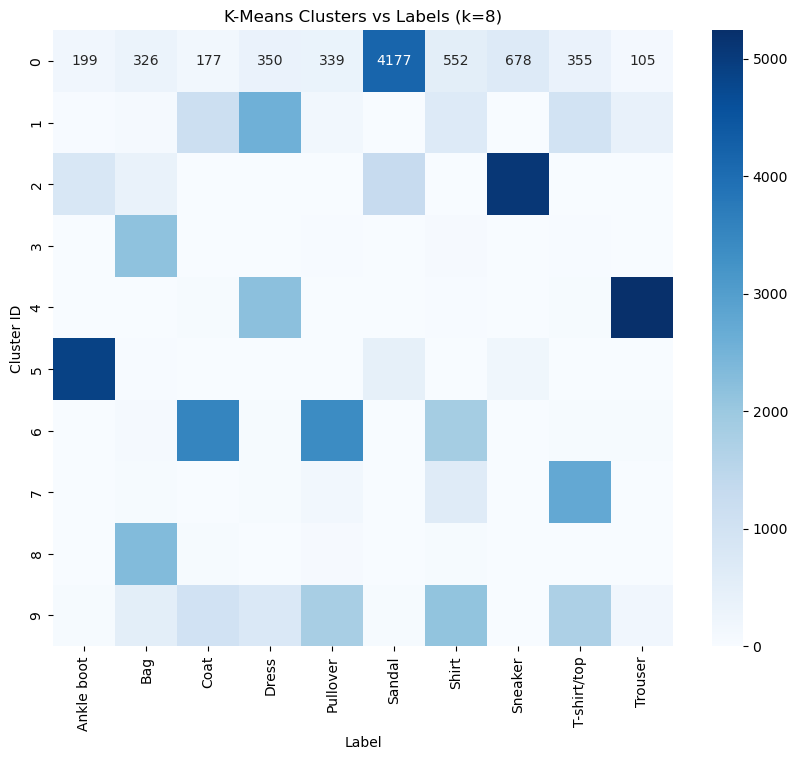

In [45]:
# visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(ct_km, annot=True, fmt='d', cmap='Blues')
plt.title(f'K-Means Clusters vs Labels (k={best_k})')
plt.ylabel('Cluster ID')
plt.xlabel('Label')
plt.show()

## Spectral Clustering 
- Attempted spectral clustering but had to significantly reduce dataset size (~1k records) to produce any results
- Algorithm produced "Graph is not fully connected, spectral embedding may not work as expected" warnings, which further indicated Spectral Clustering is not an ideal choice for this problem

## Hierarchical Clustering
- Pivoted to hierarchical clustering following Spectral Clustering difficulties
- Still ran on a subset of the data, but it was able to handle more data than Spectral

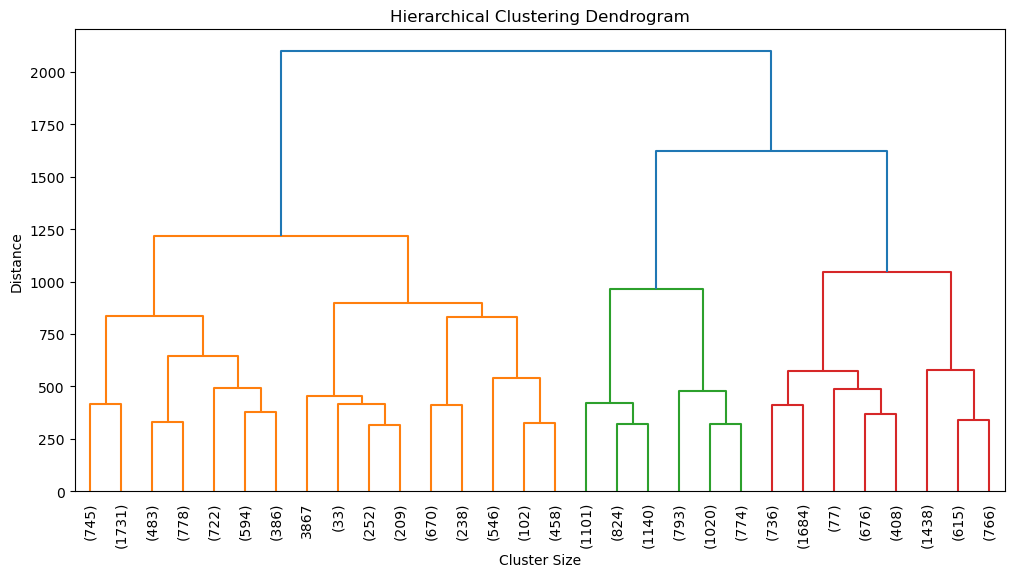

In [78]:
subset_idx = np.random.choice(len(X_pca), 20000, replace=False)
X_subset = X_pca[subset_idx]
y_subset = y_train[subset_idx]

Z = linkage(X_subset, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10.)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

Cluster 1: Sneaker (1482/2476 - 59.9%)
Cluster 2: Sandal (951/1261 - 75.4%)
Cluster 3: Ankle boot (891/1702 - 52.4%)
Cluster 4: Bag (488/495 - 98.6%)
Cluster 5: Ankle boot (850/908 - 93.6%)
Cluster 6: Bag (1029/1106 - 93.0%)
Cluster 7: Shirt (720/3065 - 23.5%)
Cluster 8: Trouser (1822/2587 - 70.4%)
Cluster 9: Coat (1313/3581 - 36.7%)
Cluster 10: T-shirt/top (1259/2819 - 44.7%)


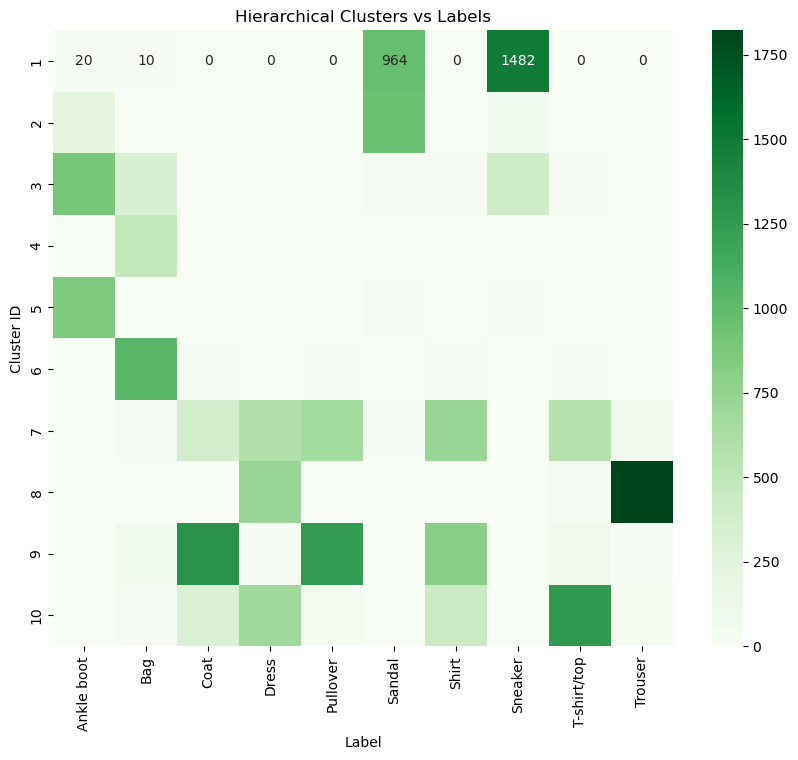

In [90]:
# cut tree at k=10 (around 600 in height) based on dendogram
cluster_labels_hc = fcluster(Z, t=600, criterion='distance')

df_hc = pd.DataFrame({'Cluster': cluster_labels_hc, 'Label': y_subset})
df_hc['Label_Name'] = df_hc['Label'].map(label_map)

ct_hc = pd.crosstab(df_hc['Cluster'], df_hc['Label_Name'])

# determine dominating label
for cluster_id in sorted(df_hc['Cluster'].unique()):
    cluster_counts = df_hc[df_hc['Cluster'] == cluster_id]['Label_Name'].value_counts()
    dominant_label = cluster_counts.idxmax()
    count = cluster_counts.max()
    total = cluster_counts.sum()
    print(f"Cluster {cluster_id}: {dominant_label} ({count}/{total} - {count/total:.1%})")

plt.figure(figsize=(10, 8))
sns.heatmap(ct_hc, annot=True, fmt='d', cmap='Greens')
plt.title('Hierarchical Clusters vs Labels')
plt.ylabel('Cluster ID')
plt.xlabel('Label')
plt.show()